In [9]:
import os
from pathlib import Path
from gurobipy import Model, GRB
from data_loader import load_prices, load_storage, load_efficiency, load_plant_capacity, load_demand
import pandas as pd

# Data Loading from data folder in the parent directory
current_dir = Path().resolve()
data_folder = os.path.join(current_dir.parent, "data")
fuel_prices_file = os.path.join(data_folder, "fuel_prices.csv")            # Price in EUR/tonne (coal,oil) or EUR/m3 (gas)
storage_file = os.path.join(data_folder, "storage.csv")                    # Max storage in tonnes/m3
efficiency_file = os.path.join(data_folder, "efficiency.csv")              # efficiency of MWh th to MWh el
plant_file = os.path.join(data_folder, "plant_capacity.csv")               # Plant capacity in MWh/month
demand_file = os.path.join(data_folder, "electricity_demand.csv")          # Monthly demand in MWh

# For comparison with previous model, we must use the same parameters
start_date = "2020-01"
end_date = "2022-12"
fuels = ["coal", "oil", "gas"]
zone = 'DK_1'  # Specify the zone for demand data
resample_method = 'M' # Monthly resampling 

try:
    fuel_prices_df = load_prices(fuel_prices_file, start_date, end_date, resample_method= resample_method)
    storage = load_storage(storage_file)
    efficiency = load_efficiency(efficiency_file)
    plant_capacity = load_plant_capacity(plant_file)
    demand_df = load_demand(demand_file, start_date, end_date, resample_method= resample_method ,zone=zone ,supply_factor=0.05)
except Exception as e:
    raise RuntimeError(f"Error loading data: {e}")


# Timesteps
T = list(range(len(demand_df)))

# Model Initialization

m = Model("Fuel_Procurement_OneMonth")

F = [fuel for fuel in fuel_prices_df.columns if fuel in fuels]

# Decision Variables
# Decision Variables (corrected filters)
x = {(fuel, t): m.addVar(lb=0, ub=storage[fuel], name=f"buy_{fuel}_{t}")
     for fuel in F for t in T}

# y = {(fuel, t): m.addVar(lb=0, ub=plant_capacity[fuel], name=f"gen_{fuel}_{t}")
#      for fuel in F for t in T}

s = {(fuel, t): m.addVar(lb=0, ub=storage[fuel], name=f"s_{fuel}_{t}")
     for fuel in F for t in T}

# periods as Month PeriodIndex (so days_in_month works)
periods = demand_df.index.to_period('M')
 
 
y = {}
for fuel in F:
    for t in T:                       
        hours_in_month = periods[t].days_in_month * 24
        # plant_capacity[fuel] is MW -> convert to MWh/month
        monthly_capacity_mwh = plant_capacity.get(fuel, 0) * hours_in_month
        y[fuel, t] = m.addVar(lb=0, ub=monthly_capacity_mwh, name=f"use_{fuel}_{t}")


m.update()



/Users/rofrug/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/First Year PhD/46750 Optimization in modern power systems/46750_g28_Assignment_2/src/data_loader.py:81: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample(resample_method).mean()
/Users/rofrug/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/First Year PhD/46750 Optimization in modern power systems/46750_g28_Assignment_2/src/data_loader.py:193: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df[selected_col].resample(resample_method).sum()


In [10]:
# Initial Storage Levels
initial_storage = {fuel: 0 for fuel in fuel_prices_df.columns if fuel in fuels}

# Constraints

# --- Add consumption (withdrawal) variables so stored fuel can be used later ---
# w = fuel consumed in a period (units same as storage units MWh th)
w = {(fuel, t): m.addVar(lb=0, ub=storage[fuel], name=f"cons_{fuel}_{t}")
     for fuel in F for t in T}

m.update()

# Demand constraint: one per time period
for t in T:
    m.addConstr(
        sum(y[fuel, t] for fuel in F) >= int(demand_df.iloc[t][zone]),
        name=f"Demand_Constraint_{t}"
    )

# efficiency constraints
for fuel in F:
    for t in T:
        m.addConstr(
            y[fuel, t] == efficiency[fuel] * w[fuel, t],
            name=f"Gen_from_Consumption_{fuel}_{t}"
        )

m.update()

# State-of-energy (SOE) constraints: storage evolves with buys (x) and withdrawals (w)
for fuel in F:
    print(f"Setting up SOE constraints for {fuel}")
    for t in T:
        print(f"  Time period {t}")
        if t == 0:
            m.addConstr(
                s[fuel, t] == initial_storage[fuel] + x[fuel, t] - w[fuel, t],
                name=f"SOE_Def_{fuel}_{t}"
            )
        else:
            m.addConstr(
                s[fuel, t] == s[fuel, t-1] + x[fuel, t] - w[fuel, t],
                name=f"SOE_Def_{fuel}_{t}"
            )

# Storage limits (explicit upper bound)
for fuel in F:
    for t in T:
        m.addConstr(
            s[fuel, t] <= storage[fuel],
            name=f"SOE_Limit_{fuel}_{t}"
        )

# Cyclic SOE (start == end)
t0 = 0
tlast = T[-1]   # last period
for fuel in F:
    m.addConstr(
        s[fuel, t0] == s[fuel, tlast],
        name=f"SOE_Cycle_{fuel}"
    )

# Objective
m.setObjective(
    sum(fuel_prices_df.iloc[t][fuel] * x[fuel, t] for fuel in F for t in T),
    GRB.MINIMIZE
)
m.update()

# Optimize
m.optimize()

# print results
if m.status == GRB.OPTIMAL:
    print("Optimal Solution Found:")
    # Purchased and generated per fuel and period
    for (fuel, t) in sorted(x.keys()):
        print(f"Purchased {x[fuel, t].X:.4f} units of {fuel} at period {t}")
    for (fuel, t) in sorted(y.keys()):
        print(f"Generated {y[fuel, t].X:.4f} MWh from {fuel} at period {t}")
    for (fuel, t) in sorted(s.keys()):
        print(f"Stored {s[fuel, t].X:.4f} units of {fuel} at period {t}")

    # Cost per fuel aggregated across periods
    total_cost = 0.0
    for fuel in F:
        cost_f = sum(fuel_prices_df.iloc[t][fuel] * x[fuel, t].X for t in T)
        print(f"Cost for {fuel}: EUR {cost_f:.2f}")
        total_cost += cost_f

    print(f"Total Cost: EUR {total_cost:.2f}")
else:
    print("No optimal solution found.")

Setting up SOE constraints for coal
  Time period 0
  Time period 1
  Time period 2
  Time period 3
  Time period 4
  Time period 5
  Time period 6
  Time period 7
  Time period 8
  Time period 9
  Time period 10
  Time period 11
  Time period 12
  Time period 13
  Time period 14
  Time period 15
  Time period 16
  Time period 17
  Time period 18
  Time period 19
  Time period 20
  Time period 21
  Time period 22
  Time period 23
  Time period 24
  Time period 25
  Time period 26
  Time period 27
  Time period 28
  Time period 29
  Time period 30
  Time period 31
  Time period 32
  Time period 33
  Time period 34
  Time period 35
Setting up SOE constraints for oil
  Time period 0
  Time period 1
  Time period 2
  Time period 3
  Time period 4
  Time period 5
  Time period 6
  Time period 7
  Time period 8
  Time period 9
  Time period 10
  Time period 11
  Time period 12
  Time period 13
  Time period 14
  Time period 15
  Time period 16
  Time period 17
  Time period 18
  Time period 

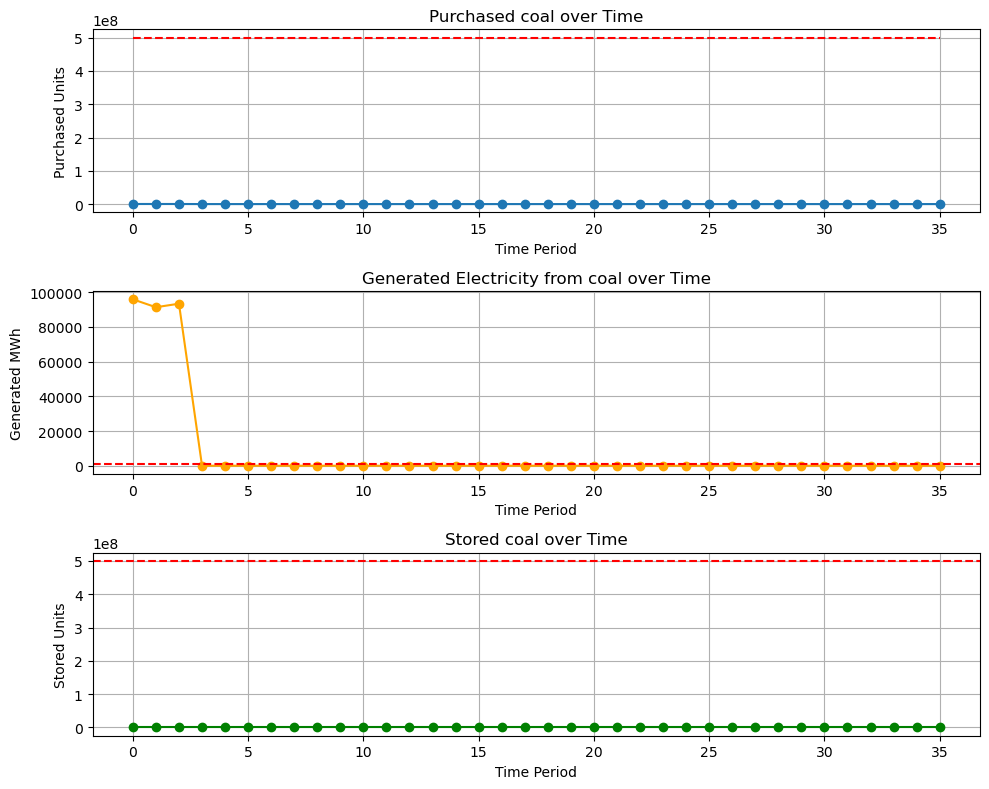

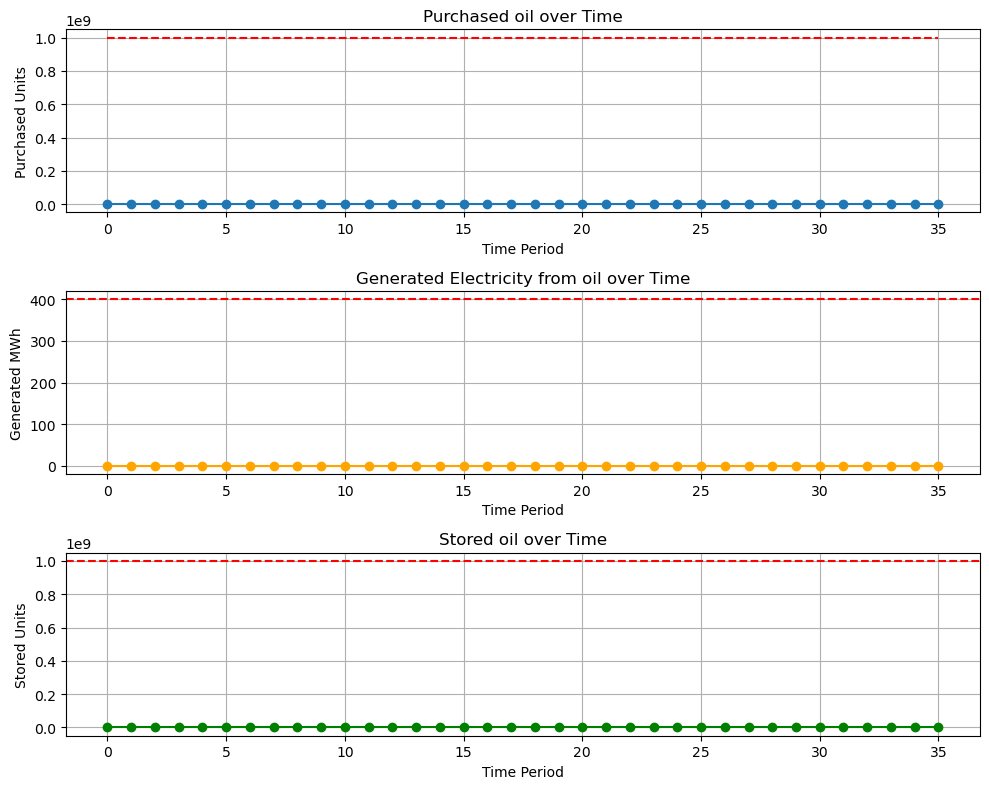

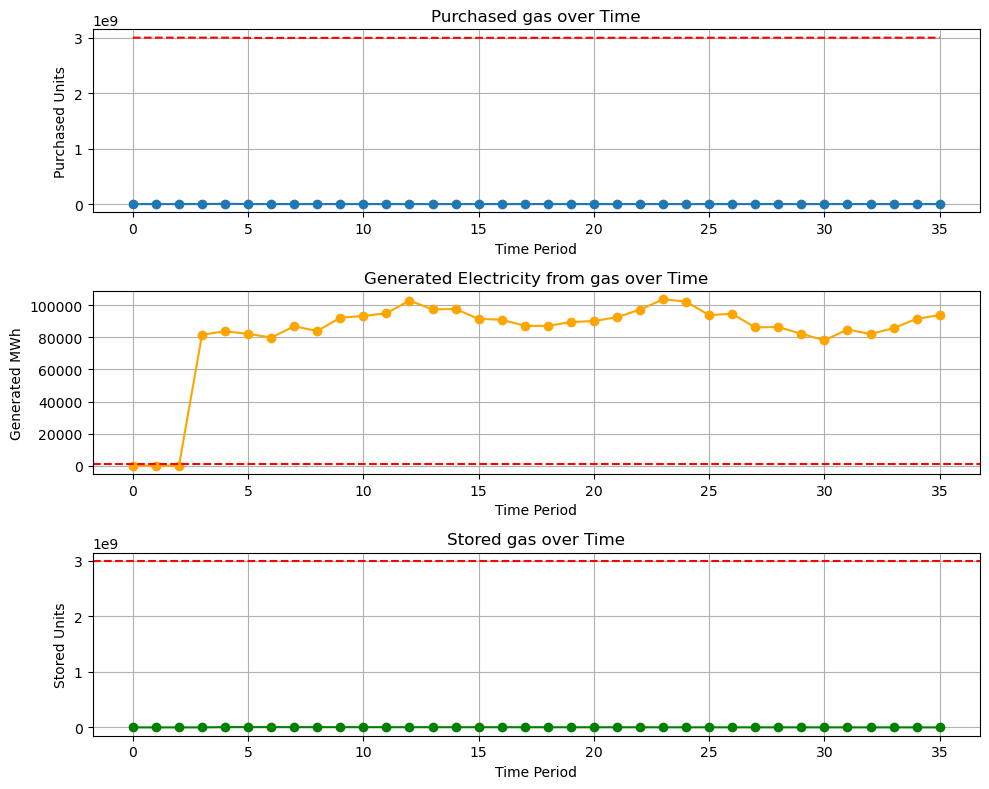

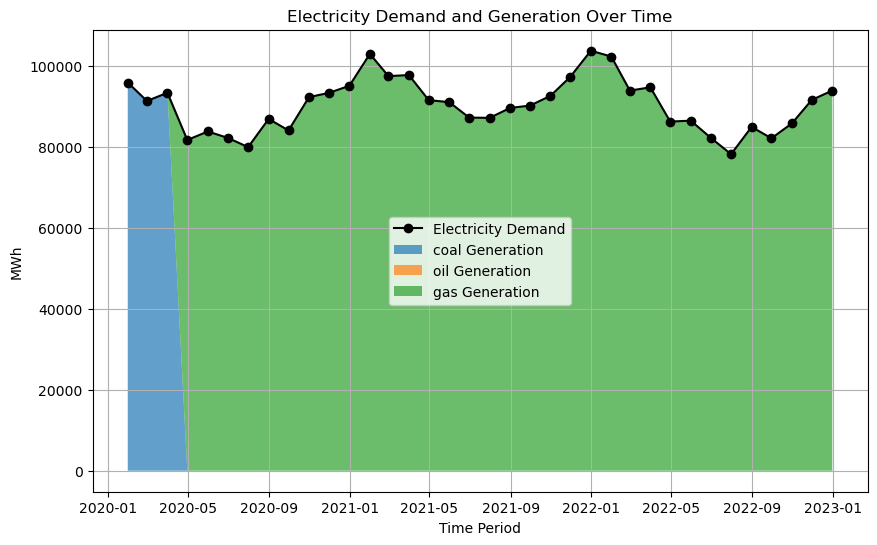

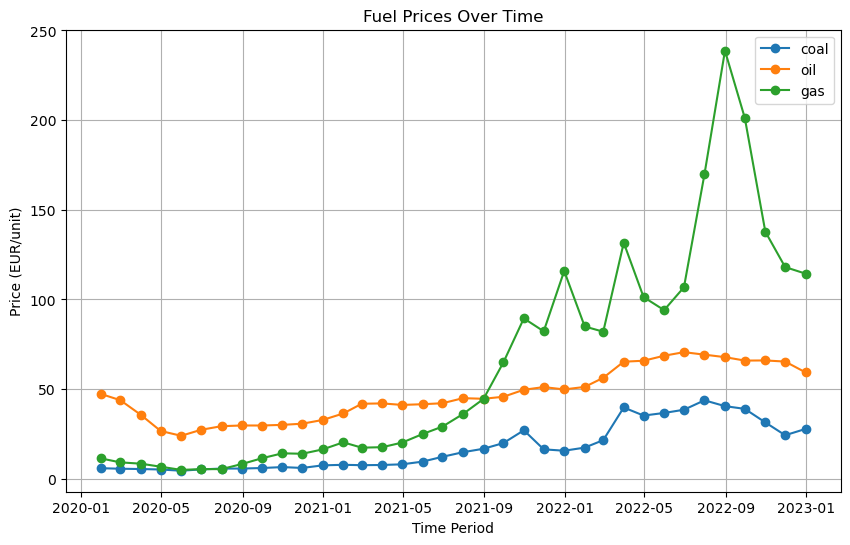

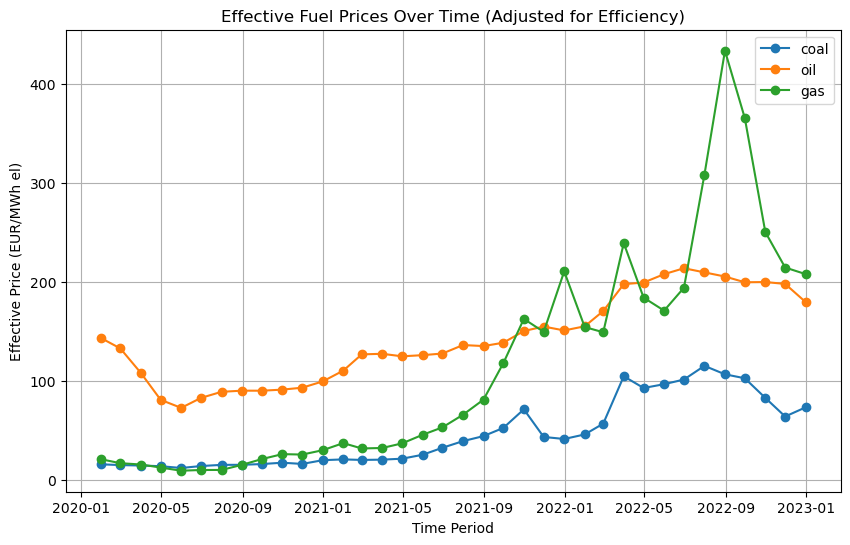

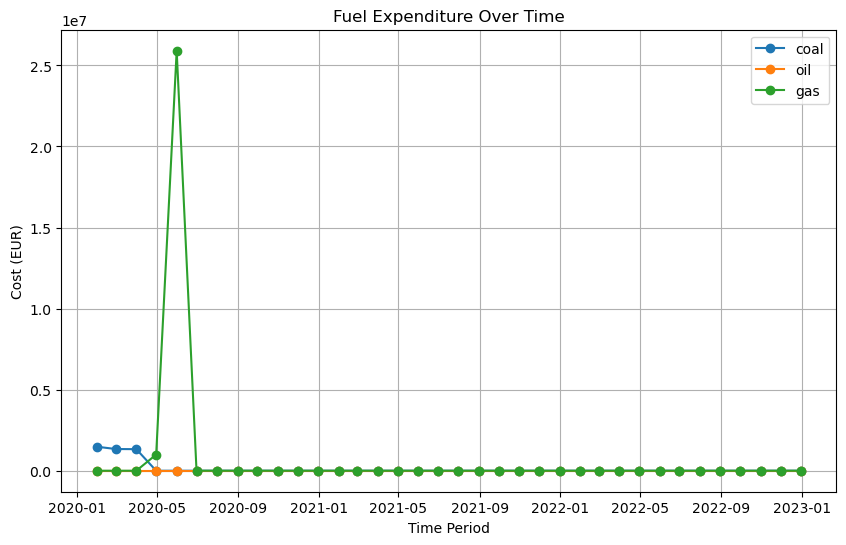

In [11]:
# plot purchased, generated, and stored fuel over time with a red line showing maximum plant capacity, and storage capacity respectively
import matplotlib.pyplot as plt

time_periods = [t for t in T]

for fuel in F:
    purchased = [x[fuel, t].X for t in T]
    generated = [y[fuel, t].X for t in T]
    stored = [s[fuel, t].X for t in T]
    efficiency_corrected_demand = [float(demand_df.iloc[t][zone]) / efficiency[fuel] for t in T]
    # Get maximum purchase capacity by calculating leftover storage from last round plus either efficiency corrected plant capacity or total demand
    stored_last = [0] + stored[:-1]
    max_purchase_capacity = [storage[fuel] - row + plant_capacity[fuel]/efficiency[fuel] for row in stored_last]
    max_purchase_demand = [ stor + dem for stor,dem in zip([storage[fuel] - row for row in stored_last],
                                                           efficiency_corrected_demand) ]

    max_purchase = [min(cap, dem) for cap, dem in zip(max_purchase_capacity, max_purchase_demand)]

    plt.figure(figsize=(10, 8))
    plt.subplot(3, 1, 1)
    plt.plot(time_periods, purchased, marker='o')
    plt.plot(time_periods,max_purchase, color='r', linestyle='--', label='Leftover Storage + Plant Capacity')
    plt.title(f'Purchased {fuel} over Time')
    plt.xlabel('Time Period')
    plt.ylabel('Purchased Units')
    plt.grid()

    plt.subplot(3, 1, 2)
    plt.plot(time_periods, generated, marker='o', color='orange')
    plt.axhline(y=plant_capacity[fuel], color='r', linestyle='--', label='Max Plant Capacity')
    plt.title(f'Generated Electricity from {fuel} over Time')
    plt.xlabel('Time Period')
    plt.ylabel('Generated MWh')
    plt.grid()

    plt.subplot(3, 1, 3)
    plt.plot(time_periods, stored, marker='o', color='green')
    plt.axhline(y=storage[fuel], color='r', linestyle='--', label='Max Storage Capacity')
    plt.title(f'Stored {fuel} over Time')
    plt.xlabel('Time Period')
    plt.ylabel('Stored Units')
    plt.grid()

    plt.tight_layout()
    plt.show()


# Plot demand over time employing fill_between to show contributions from each fuel
plt.figure(figsize=(10, 6))
plt.plot(demand_df.index, demand_df[zone], marker='o', label='Electricity Demand', color='black')
bottom = [0]*len(T)
for fuel in F:
    generation = [y[fuel, t].X for t in T]
    plt.fill_between(demand_df.index, bottom, [b + g for b, g in zip(bottom, generation)], label=f'{fuel} Generation', alpha=0.7)
    bottom = [b + g for b, g in zip(bottom, generation)]
plt.title('Electricity Demand and Generation Over Time')
plt.xlabel('Time Period')
plt.ylabel('MWh')
plt.legend()
plt.grid()
plt.show()

# Plot prices over time
plt.figure(figsize=(10, 6))
for fuel in F:
    plt.plot(fuel_prices_df.index, fuel_prices_df[fuel], marker='o', label=fuel)
plt.title('Fuel Prices Over Time')
plt.xlabel('Time Period')
plt.ylabel('Price (EUR/unit)')
plt.legend()
plt.grid()
plt.show()

# plot prices divided by efficiency to see effective cost per MWh electricity
plt.figure(figsize=(10, 6))
for fuel in F:
    effective_price = fuel_prices_df[fuel] / efficiency[fuel]
    plt.plot(fuel_prices_df.index, effective_price, marker='o', label=fuel)
plt.title('Effective Fuel Prices Over Time (Adjusted for Efficiency)')
plt.xlabel('Time Period')
plt.ylabel('Effective Price (EUR/MWh el)')
plt.legend()
plt.grid()
plt.show()

# Plot cost over time
plt.figure(figsize=(10, 6))
for fuel in F:
    cost_over_time = [fuel_prices_df.iloc[t][fuel] * x[fuel, t].X for t in T]
    plt.plot(fuel_prices_df.index, cost_over_time, marker='o', label=fuel)
plt.title('Fuel Expenditure Over Time')
plt.xlabel('Time Period')
plt.ylabel('Cost (EUR)')
plt.legend()
plt.grid()
plt.show()


Total Cost from Model 1: EUR 1651625.08
Total Cost from Model 2: EUR 31052242.97


Text(0, 0.5, 'Cumulative Cost (EUR)')

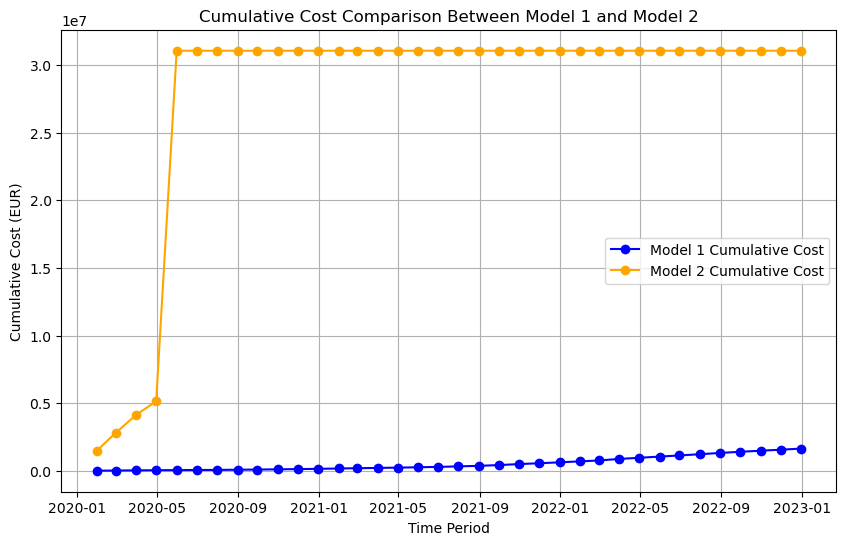

In [12]:
# Compare total cost to Model 1 as stored in Accumulated_Cost column in "results/model1/running_cost_results.csv"
import pandas as pd
model1_results_file = os.path.join(current_dir.parent, "results", "model1", "model1_results.csv")
model1_results_df = pd.read_csv(model1_results_file)
model1_total_cost = model1_results_df['Accumulated_Cost'].iloc[-1]
print(f"Total Cost from Model 1: EUR {model1_total_cost:.2f}")
print(f"Total Cost from Model 2: EUR {total_cost:.2f}")
# Compare costs
if abs(total_cost - model1_total_cost) < 1e-2:
    print("Total costs from Model 1 and Model 2 match closely.")

# Results Analysis and Visualization
model2_cost = []
for t in T:
    period_cost = sum(fuel_prices_df.iloc[t][fuel] * x[fuel, t].X for fuel in F)
    model2_cost.append(period_cost)
plt.figure(figsize=(10, 6))
plt.plot(demand_df.index, model1_results_df['Accumulated_Cost'], marker='o', label='Model 1 Cumulative Cost', color='blue')
plt.plot(demand_df.index, pd.Series(model2_cost).cumsum(), marker='o', label='Model 2 Cumulative Cost', color='orange')
plt.legend()
plt.title('Cumulative Cost Comparison Between Model 1 and Model 2')
plt.grid()
plt.xlabel('Time Period')
plt.ylabel('Cumulative Cost (EUR)')

In [13]:
# Save results to csv
results_dir = os.path.join(current_dir.parent, "results", "model2")
os.makedirs(results_dir, exist_ok=True)
results_file = os.path.join(results_dir, "model2_results.csv")
import pandas as pd
model2_results_df = pd.DataFrame({
    'Time_Period': demand_df.index,
    'Cost_EUR': model2_cost,
    'Accumulated_Cost': pd.Series(model2_cost).cumsum(),
    'Coal_Bought': [x['coal', t].X for t in T],
    'Oil_Bought': [x['oil', t].X for t in T],
    'Gas_Bought': [x['gas', t].X for t in T],
    'Coal_Generated_MWh': [y['coal', t].X for t in T],
    'Oil_Generated_MWh': [y['oil', t].X for t in T],
    'Gas_Generated_MWh': [y['gas', t].X for t in T],
    'Coal_Stored': [s['coal', t].X for t in T],
    'Oil_Stored': [s['oil', t].X for t in T],
    'Gas_Stored': [s['gas', t].X for t in T],
})
model2_results_df.to_csv(results_file, index=False)
print(f"Model 2 results saved to {results_file}")


Model 2 results saved to /Users/rofrug/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/First Year PhD/46750 Optimization in modern power systems/46750_g28_Assignment_2/results/model2/model2_results.csv
